# Circuit with Benchmarking

In [1]:
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
import statsmodels.api as sm

from doe_modules.design import DOE, FullFactorial, CLOO, PlackettBurman, d_criterion, DOCLOO
from doe_modules.plot import bio_multicomp
from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.simulation import Circuit, MLR, AbstractSimulator

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    simulator: AbstractSimulator = Circuit
    run_names: list = None
    suffix: str = "_circuit"

conf = Config()

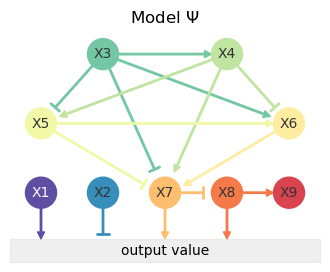

In [3]:
fig, ax = plt.subplots(figsize=(4, 3))

conf.simulator().plot(ax=ax)
ax.set_title(conf.simulator().name)

if conf.savefig:
    fig.savefig(f"{conf.out}/sim_model{conf.suffix}", **kwarg_savefig)

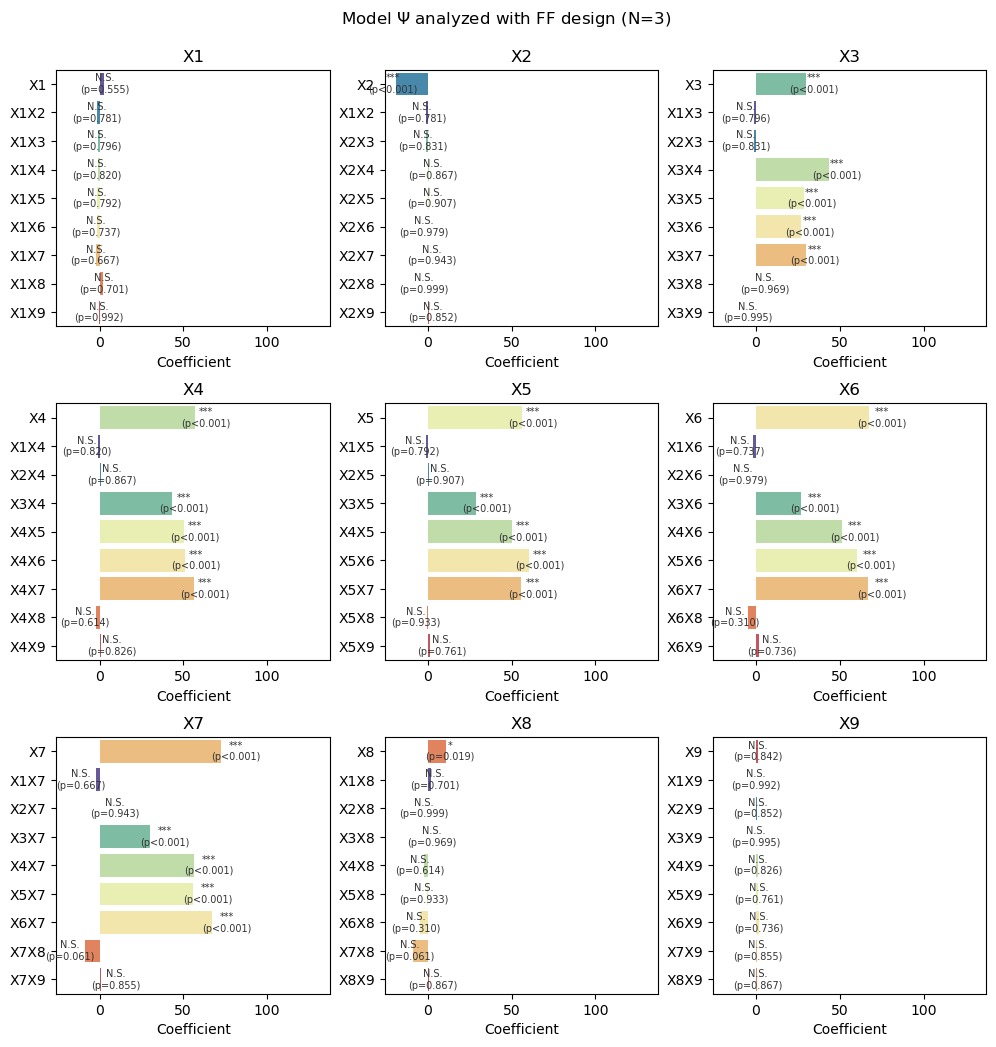

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(hspace=.3)

model = conf.simulator()
model.simulate(design=FullFactorial, n_rep=3)

mlr = MLR(model, interactions=True)

for i, a in enumerate(ax.ravel()):
    cmap=model.cmap.copy()
    mlr.plot(ax=a, cmap=[cmap.pop(i)]+cmap, anova=True, regex=f"X{i + 1}", jitter_ratio=.1)
    a.set_title(f"X{i + 1}")

common_xlim = np.abs(
    np.array([a.get_xlim() for a in ax.ravel()])
).max(axis=0) * np.array([-1, 1])

[a.set_xlim(common_xlim) for a in ax.ravel()]

fig.suptitle(
    f"{conf.simulator().name} analyzed with {model.metadata['design']} design (N={model.metadata['n_rep']})", 
    y=.93
);

if conf.savefig:
    fig.savefig(f"{conf.out}/ff_sim_mlr_all{conf.suffix}", **kwarg_savefig)

In [5]:
noise_conf = [
    dict(kwarg_err=dict(loc=0, scale=.5)),
    dict(kwarg_err=dict(loc=0, scale=1)),
    dict(kwarg_err=dict(loc=0, scale=2)),
]

noise_names = [
    r"$\varepsilon_{i,j},\varepsilon_{y,j}\sim\mathcal{N}(0,0.5)$",
    r"$\varepsilon_{i,j},\varepsilon_{y,j}\sim\mathcal{N}(0,1)$",
    r"$\varepsilon_{i,j},\varepsilon_{y,j}\sim\mathcal{N}(0,2)$"
]

n_arr = [1, 2, 3]

conditions = dict(
    ff=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_arr))),
    pb=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_arr))),
    cloo=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_arr))),
)

designs = dict(
    ff=FullFactorial,
    pb=PlackettBurman,
    cloo=CLOO,
)

In [6]:
for k, models in conditions.items():
    [
        m.simulate(
            design=designs[k],
            n_rep=n_arr[i % len(n_arr)],
            model_kwargs=noise_conf[i // len(n_arr)],
        ) for i, m in enumerate(models)
    ]

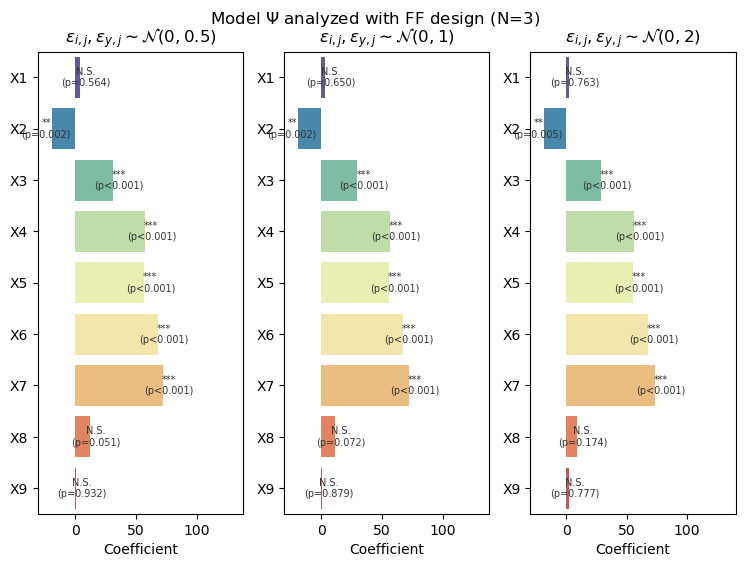

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(9, 6))

for i, a in enumerate(ax.ravel()):
    ff_mlr = MLR(conditions["ff"][3 * i + 2])
    ff_mlr.plot(anova=True, jitter_ratio=.05, ax=a)
    a.set_title(noise_names[i])

fig.suptitle(f"{conf.simulator().name} analyzed with {ff_mlr.metadata['design']} design (N=3)", y=.95)

if conf.savefig:
    fig.savefig(f"{conf.out}/groundtrue_results{conf.suffix}", **kwarg_savefig)

In [8]:
ground_truth = [
    MLR(conditions["ff"][3 * (i // len(n_arr)) + 2]).summary(
        anova=True, dtype=int
    ) for i, _ in enumerate(conditions["ff"])
]

pb_k, cloo_k = [], []
pb_dd, cloo_dd = [], []
kappa = lambda res, gt: np.nan if res.isna().all() else cohen_kappa_score(res, gt, weights="linear")

for pb, cloo, gt in zip(conditions["pb"], conditions["cloo"], ground_truth):
    pb_res = MLR(pb).summary(anova=True, dtype=int)
    cloo_res = MLR(cloo).summary(anova=True, dtype=int)
    pb_k += [kappa(pb_res, gt)]
    cloo_k += [kappa(cloo_res, gt)]
    pb_dd += [d_criterion(sm.add_constant(pb.exmatrix))]
    cloo_dd += [d_criterion(sm.add_constant(cloo.exmatrix))]

/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


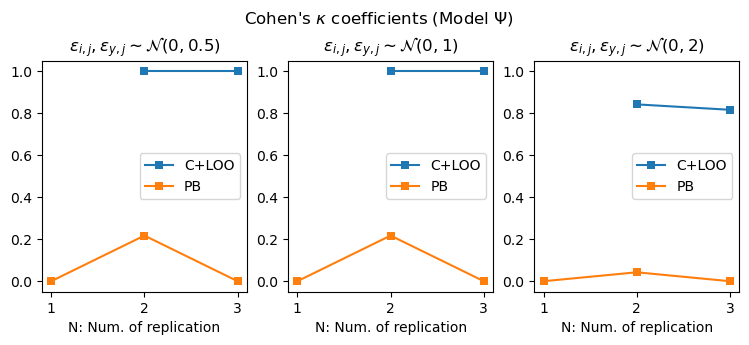

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

df = pd.DataFrame({
    "n": n_arr * 3,
    "err": np.ravel([[v] * 3 for v in [.5, 1, 2]]),
    "pb_k": pb_k,
    "cloo_k": cloo_k,
    "pb_dd": pb_dd,
    "cloo_dd": cloo_dd,
})

for i, a in enumerate(ax.ravel()):
    e = df.err.unique()[i]
    sns.lineplot(
        data=df[df.err == e], x="n", y="cloo_k", marker="s", 
        ax=a, label=conditions["cloo"][0].metadata["design"], 
        markeredgewidth=0,
    )
    sns.lineplot(
        data=df[df.err == e], x="n", y="pb_k", marker="s", 
        ax=a, label=conditions["pb"][0].metadata["design"],
        markeredgewidth=0,
    )
    a.set_ylim(-0.05, 1.05)
    a.set(title=noise_names[i], xlabel="N: Num. of replication", ylabel="")
    a.legend(loc="best")

fig.suptitle(r"Cohen's $\kappa$" + f" coefficients ({conf.simulator().name})", y=1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks{conf.suffix}", **kwarg_savefig)

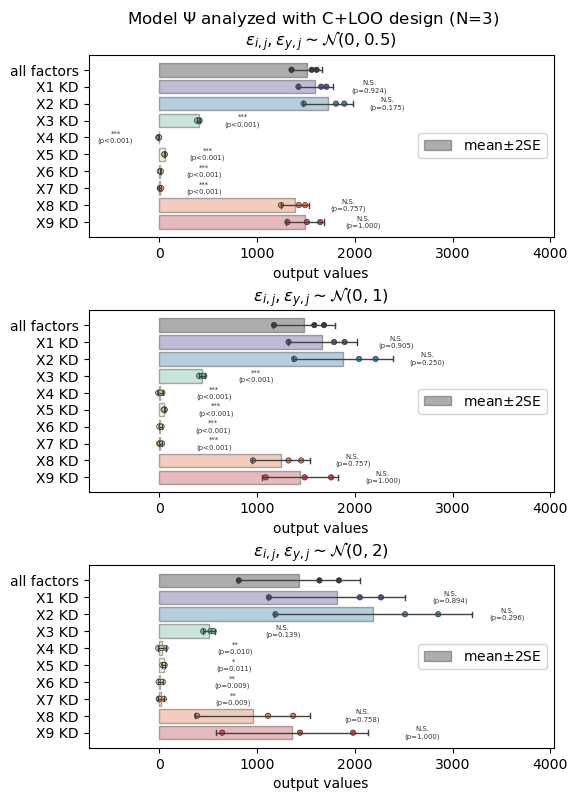

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(6, 9))
plt.subplots_adjust(hspace=.4)

for i, a in enumerate(ax.ravel()):
    model = conditions["cloo"][3 * i + 2]
    bio_multicomp(model, cmap=model.cmap, ax=a, text_kwargs={"size": 5}, xscales=[4, 1.2], jitter_ratio=.2)
    a.set_title(noise_names[i])

    # for x, y, t, c in zip([-160, 120], [0, 0], ["Upregulation", "Downregulation"], ["C3", "C0"]):
    #     a.text(x, y, t, color=c, ha="center", va="center", size=11)

    a.legend(loc="center right")

xlim = (lambda arr: [arr.min(), arr.max()])(np.array([a.get_xlim() for a in ax.ravel()]))

[a.set_xlim(*xlim) for a in ax.ravel()]
    
fig.suptitle(f"{conf.simulator().name} analyzed with {model.metadata['design']} design (N={model.metadata['n_rep']})", y=.93)

if conf.savefig:
    fig.savefig(f"{conf.out}/intuitive_plots_for_benchmarking{conf.suffix}", **kwarg_savefig)

In [11]:
n_add = [2, 6, 10]

doptims = dict(
    docloo=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_add)))
)

In [12]:
for i, m in enumerate(doptims["docloo"]):
    m.simulate(
        design=DOCLOO,
        n_rep=3,
        n_add = n_add[i % len(n_add)],
        model_kwargs=noise_conf[i // len(n_add)],
    )

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this wa

In [13]:
do_k = []

for do, gt in zip(doptims["docloo"], ground_truth):
    do_res = MLR(do).summary(anova=True, dtype=int)
    do_k += [kappa(do_res, gt)]

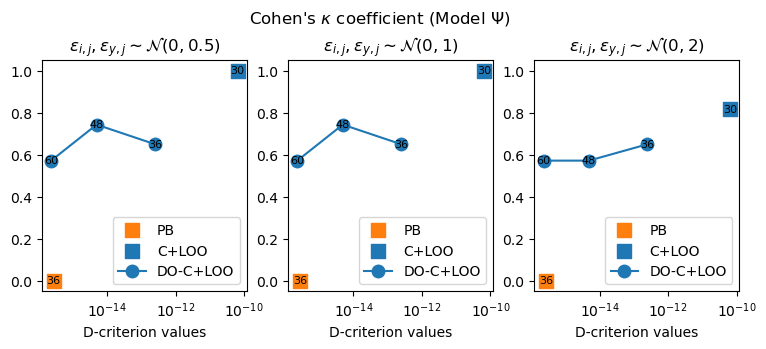

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

df2 = pd.DataFrame({
    "nmax": [len(m.exmatrix) for m in doptims["docloo"]],
    "d": np.fromiter(
        map(
            d_criterion, 
            map(
                sm.add_constant, 
                [m.exmatrix for m in doptims["docloo"]]
            )
        ), 
        float
    ),
    "err": np.ravel([[v] * 3 for v in [.5, 1, 2]]),
    "do_k": do_k
})

d_pb = d_criterion(sm.add_constant(pb.exmatrix))
d_cloo = d_criterion(sm.add_constant(cloo.exmatrix))

for i, a in enumerate(ax.ravel()):
    e = df2.err.unique()[i]
    pb = conditions["pb"][3 * i + 2]
    cloo = conditions["cloo"][3 * i + 2]
    a.scatter(d_pb, pb_k[3 * i + 2], marker=",", color="C1", label="PB", s=100)
    a.scatter(d_cloo, cloo_k[3 * i + 2], marker=",", color="C0", label="C+LOO", s=100)
    sns.lineplot(
        data=df2[df2.err == e], x="d", y="do_k", marker="o", 
        ax=a, label="DO-C+LOO", 
        markeredgewidth=0, color="C0", markersize=10
    )
    a.set_ylim(-0.05, 1.05)
    a.set(title=noise_names[i], xlabel="D-criterion values", ylabel="")
    a.set_xscale("log")
    a.legend(loc="lower right")
    
    for x, y, t in zip(
        list(df2[df2.err == e].d) + [d_pb, d_cloo],
        list(df2[df2.err == e].do_k) + [pb_k[3 * i + 2], cloo_k[3 * i + 2]],
        list(df2[df2.err == e].nmax) + [len(pb.exmatrix), len(cloo.exmatrix)],
    ):
        a.text(x, y, t, ha="center", va="center", size=8)

fig.suptitle(r"Cohen's $\kappa$" + f" coefficient ({conf.simulator().name})", y=1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks_with_do{conf.suffix}", **kwarg_savefig)